In [4]:
import pandas as pd
import numpy as np
import os
from scipy import signal
import statsmodels
from scipy.stats import norm
from math import factorial
import time
from scipy import stats
import scipy as scipy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(threshold=5)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf

yf.pdr_override()

In [11]:
START_DATE = "2015-01-01"
END_DATE = "2020-01-01"

In [12]:
def build_sp500_dataset(start=START_DATE, end=END_DATE):

    index_data = pdr.get_data_yahoo("SPY", start=START_DATE, end=END_DATE)
    index_data.to_csv("index2.csv")

In [13]:
def build_dataset_iteratively(date_start=START_DATE, date_end=END_DATE):
    
    ticker_list = list(pd.read_csv('tickers.csv',  encoding='latin-1')['Symbol'])

    df = pd.DataFrame()

    for ticker in ticker_list:
        ticker = ticker.upper()

        stock_ohlc = pdr.get_data_yahoo(ticker, start=date_start, end=date_end)
        if stock_ohlc.empty:
            print(f"No data for {ticker}")
            continue
            
        adj_close = stock_ohlc["Adj Close"].rename(ticker)
        df = pd.concat([df, adj_close], axis=1)
                
    df.to_csv("stocks2.csv")

In [15]:
# build_sp500_dataset(start=START_DATE, end=END_DATE)
# build_dataset_iteratively(date_start=START_DATE, date_end=END_DATE)

In [16]:
tickers_mapping = pd.read_csv('Tickers.csv',  encoding='latin-1')
tickers_sorted = tickers_mapping.sort_values(['Sector']).Symbol
tickers_mapping.index = tickers_mapping['Symbol']

prices = pd.read_csv('stocks.csv')
prices.index = pd.DatetimeIndex(prices['Unnamed: 0'])
prices = prices.iloc[:,1:]
index = pd.read_csv('index.csv')
index.index = pd.DatetimeIndex(index['Date'])
raw_prices = pd.concat([prices, index['Adj Close'].rename('INDEX')], axis=1)        

returns = raw_prices.pct_change(1)
betas = ((returns.rolling(60).corr(returns['INDEX']))*\
                            (returns.rolling(60).std().div(returns['INDEX'].rolling(60).std(),axis = 0))).shift(1)
idio_returns = returns - betas.mul(returns['INDEX'], axis = 0)
idio_std_returns = idio_returns.div(idio_returns.std(0), 1)

clean_returns = returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_returns = idio_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)
clean_idio_std_returns = idio_std_returns.loc[:,tickers_sorted].dropna(0, how = 'all').dropna(1)

<AxesSubplot:>

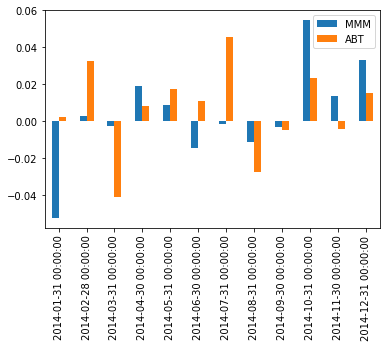

In [17]:
idio_returns.iloc[:,:2].resample('M', how = 'sum')['2014'].plot(kind='bar')

<AxesSubplot:>

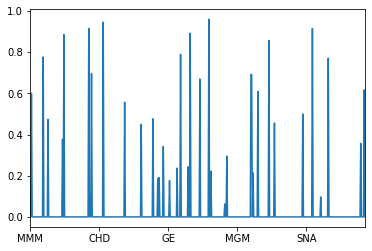

In [18]:
((raw_prices.isna().sum())/(raw_prices.count() + raw_prices.isna().sum())).plot()

Unsupervised Learning: Clustering, Dimension Reduction, Associative Rules

In [19]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import collections
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

In [20]:
def _get_quasi_diag(link):
    
    return sch.to_tree(link, rd=False).pre_order()

def _get_cluster_var(cov, cluster_items):
    
    cov_slice = cov.loc[cluster_items, cluster_items]
    weights = 1 / np.diag(cov_slice)  
    weights /= weights.sum()
    return np.linalg.multi_dot((weights, cov_slice, weights))


def _raw_hrp_allocation(cov, ordered_tickers):

    w = pd.Series(1, index=ordered_tickers)
    cluster_items = [ordered_tickers] 

    while len(cluster_items) > 0:
        cluster_items = [i[j:k] for i in cluster_items for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1] 
        
        for i in range(0, len(cluster_items), 2):
            first_cluster = cluster_items[i]
            second_cluster = cluster_items[i + 1]
            first_variance = _get_cluster_var(cov, first_cluster)
            second_variance = _get_cluster_var(cov, second_cluster)
            alpha = 1 - first_variance / (first_variance + second_variance)
            w[first_cluster] *= alpha  
            w[second_cluster] *= 1 - alpha  
            
    return w

def optimize(returns, linkage_method="single"):

    corr, cov = returns.corr(), returns.cov()
    matrix = np.sqrt(np.clip((1.0 - corr) / 2.0, a_min=0.0, a_max=1.0))
    dist = ssd.squareform(matrix, checks=False)
    clusters = sch.linkage(dist, linkage_method)
    sort_ix = _get_quasi_diag(clusters)
    ordered_tickers = corr.index[sort_ix].tolist()
    hrp = _raw_hrp_allocation(cov, ordered_tickers)
    weights = collections.OrderedDict(hrp.sort_index())

    return weights

def demo(returns, linkage_method="single", use_returns = True):
    
    if use_returns == True: 
        returns = returns.T
        
        clusters = sch.linkage(returns, method='complete', metric='cityblock')
        cluster = AgglomerativeClustering(n_clusters=10, affinity='manhattan', linkage='complete')
        output = cluster.fit_predict(returns)    
        return output    
    
    if use_returns == False: 
        corr  = returns.corr()
        matrix = np.sqrt(np.clip((1.0 - corr) / 2.0, a_min=0.0, a_max=1.0))
        dist = ssd.squareform(matrix, checks=False)
        
        clusters = sch.linkage(dist, method='complete', metric='cityblock')
        cluster = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='complete')
        output = cluster.fit_predict(matrix)   
        return output 

In [21]:
# dend = shc.dendrogram(shc.linkage(returns, method='complete', metric='cityblock'))
# weights = optimize(clean_idio_returns)

In [22]:
output = demo(clean_idio_std_returns)

In [23]:
output_table = pd.DataFrame({'firms' : clean_idio_std_returns.T.index, 'Cluster' : list(output)})
output_table.index = output_table.loc[:,'firms']
output_table = pd.concat([output_table, tickers_mapping[tickers_mapping['Symbol'].isin(output_table.index)]], 1)

In [24]:
classify_table = {}
for this_sector in output_table['Sector'].unique():
    classify_table[this_sector] = output_table[output_table['Sector'] == this_sector]['Cluster'].value_counts()
pd.concat(classify_table, 1).T

,0,1,2,3,4,5,6,7,8,9
Communication Services,5.000000,3.000000,3.000000,7.000000,nan,nan,nan,nan,nan,nan
Consumer Discretionary,13.000000,26.000000,7.000000,5.000000,nan,nan,nan,3.000000,nan,nan
Consumer Staples,nan,nan,27.000000,2.000000,nan,nan,nan,nan,nan,nan
Energy,nan,nan,nan,nan,nan,19.000000,nan,nan,nan,nan
Financials,nan,nan,nan,4.000000,56.000000,nan,nan,nan,nan,nan
Health Care,nan,nan,7.000000,38.000000,nan,nan,nan,nan,13.000000,nan
Industrials,6.000000,1.000000,nan,10.000000,nan,1.000000,nan,36.000000,9.000000,nan
Information Technology,nan,45.000000,nan,18.000000,nan,nan,nan,2.000000,nan,nan
Materials,1.000000,nan,nan,nan,nan,3.000000,nan,19.000000,nan,nan
Real Estate,5.000000,1.000000,nan,1.000000,nan,nan,23.000000,nan,nan,nan


In [25]:
output_table[output_table['Cluster'] == 3][:5]

,firms,Cluster,Symbol,Name,Sector,Industry
A,A,3,A,Agilent Technologies,Health Care,Health Care Equipment
ABMD,ABMD,3,ABMD,Abiomed,Health Care,Health Care Equipment
ACN,ACN,3,ACN,Accenture,Information Technology,IT Consulting & Other Services
ADP,ADP,3,ADP,Automatic Data Processing,Information Technology,Data Processing & Outsourced Services
ALGN,ALGN,3,ALGN,Align Technology,Health Care,Health Care Supplies


In [350]:
output_table[output_table['Sector'] == 'Financials'].sort_values(['Cluster'])[:5]

,firms,Cluster,Symbol,Name,Sector,Industry
MCO,MCO,3,MCO,Moody's Corp,Financials,Financial Exchanges & Data
MKTX,MKTX,3,MKTX,MarketAxess,Financials,Financial Exchanges & Data
MSCI,MSCI,3,MSCI,MSCI Inc,Financials,Financial Exchanges & Data
SPGI,SPGI,3,SPGI,S&P Global Inc.,Financials,Financial Exchanges & Data
MMC,MMC,4,MMC,Marsh & McLennan,Financials,Insurance Brokers


In [338]:
data = clean_idio_std_returns.T
model = KMeans(n_clusters=11, tol = 0.0001, max_iter = 3, algorithm = 'elkan')
model.fit(data)
a = model.labels_
print(model.n_iter_, model.inertia_)

3 439509.7058393221


In [339]:
output_table = pd.DataFrame({'firms' : clean_idio_std_returns.T.index, 'Cluster' : list(a)})
output_table.index = output_table.loc[:,'firms']
output_table = pd.concat([output_table, tickers_mapping[tickers_mapping['Symbol'].isin(output_table.index)]], 1)

In [340]:
classify_table = {}
for this_sector in output_table['Cluster'].unique():
    classify_table[this_sector] = output_table[output_table['Cluster'] == this_sector]['Sector'].value_counts()
pd.concat(classify_table, 1)

,0,1,2,3,4,5,6,7,8,9,10
Communication Services,4.000000,3.000000,nan,nan,2.000000,nan,4.000000,nan,5.000000,nan,nan
Consumer Discretionary,32.000000,1.000000,nan,nan,nan,nan,13.000000,nan,6.000000,2.000000,nan
Consumer Staples,2.000000,27.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
Energy,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,1.000000,17.000000
Financials,nan,nan,20.000000,nan,14.000000,nan,nan,26.000000,nan,nan,nan
Health Care,4.000000,24.000000,nan,nan,25.000000,nan,3.000000,nan,1.000000,1.000000,nan
Industrials,6.000000,4.000000,nan,nan,6.000000,nan,11.000000,nan,2.000000,34.000000,nan
Information Technology,2.000000,2.000000,nan,nan,10.000000,nan,nan,nan,50.000000,1.000000,nan
Materials,nan,nan,nan,nan,2.000000,nan,4.000000,nan,nan,16.000000,1.000000
Real Estate,nan,nan,nan,nan,1.000000,23.000000,5.000000,nan,1.000000,nan,nan


In [341]:
def optimalK(data, nrefs=5, maxClusters=20):

    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(k)
            km.fit(randomReference)    
            refDisps[i] = km.inertia_
        
        km = KMeans(k)
        km.fit(data)        
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    
    return (gaps.argmax() + 1, resultsdf)

In [342]:
def init_board_gauss(N, k):
    
    n = float(N)/k
    X = []
    for i in range(k):
        c = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        s = np.random.uniform(0.05,0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])
            if abs(a) < 1 and abs(b) < 1:
                x.append([a,b])
        X.extend(x)
    X = np.array(X)[:N]
    
    return X

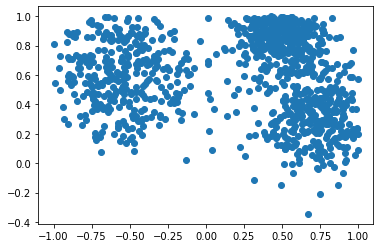

In [343]:
data = init_board_gauss(1000, 3)
plt.scatter(data[:,0], data[:,1])

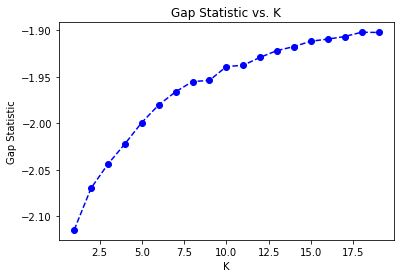

In [328]:
data = np.clip(clean_idio_std_returns.T, -2, 2)
_, df = optimalK(data)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');